# Laboratorio #10 - Explainable AI
- Mark Albrand - 21004
- Jimena Hernández - 21199

In [7]:
#Imports
import pandas as pd

import matplotlib.pyplot as plt

import xgboost as xgb
from xgboost import plot_importance

import shap
shap.initjs()

import sys
sys.path.append('../')
import utils

In [8]:
#Load the dataset
data = pd.read_csv("https://raw.githubusercontent.com/fenago/datasets/refs/heads/main/insurance.csv")

print("Number of rows: {}".format(len(data)))
data.head(10)

Number of rows: 1338


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [9]:
#Feature engineering
data['sex'] = [1 if s =='male' else 0 for s in data['sex']]
data['smoker'] = [1 if s =='yes' else 0 for s in data['smoker']]

data['region.SW'] = [1 if r =='southwest' else 0 for r in data['region']]
data['region.SE'] = [1 if r =='southeast' else 0 for r in data['region']]
data['region.NW'] = [1 if r =='northwest' else 0 for r in data['region']]
data['region.NE'] = [1 if r =='northeast' else 0 for r in data['region']]

data = data.drop('region', axis=1)

data.head(10)

,age,sex,bmi,children,smoker,charges,region.SW,region.SE,region.NW,region.NE
0,19,0,27.900,0,1,16884.92400,1,0,0,0
1,18,1,33.770,1,0,1725.55230,0,1,0,0
2,28,1,33.000,3,0,4449.46200,0,1,0,0
3,33,1,22.705,0,0,21984.47061,0,0,1,0
4,32,1,28.880,0,0,3866.85520,0,0,1,0
5,31,0,25.740,0,0,3756.62160,0,1,0,0
6,46,0,33.440,1,0,8240.58960,0,1,0,0
7,37,0,27.740,3,0,7281.50560,0,0,1,0
8,37,1,29.830,2,0,6406.41070,0,0,0,1
9,60,0,25.840,0,0,28923.13692,0,0,1,0


Text(0.5, 0, 'Actual')

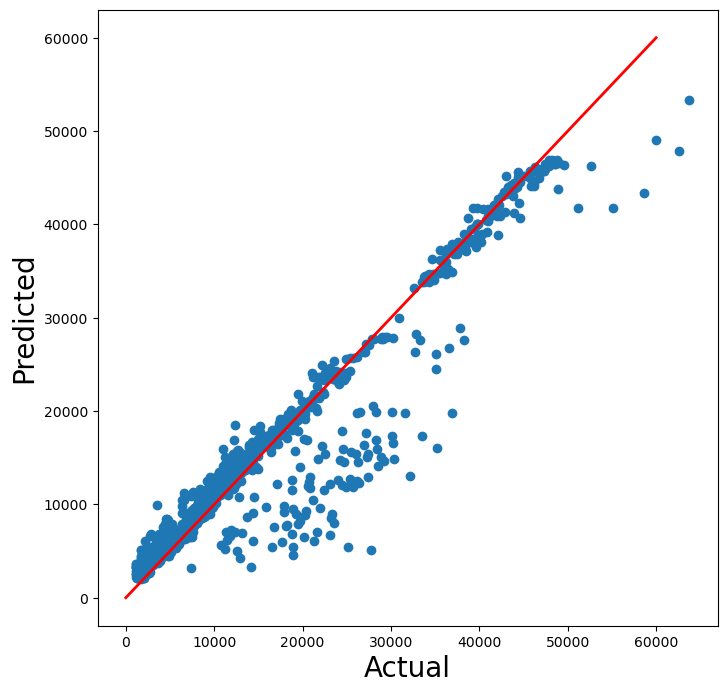

In [10]:
y = data['charges']
X = data.drop('charges', axis=1)

#Train model
model = xgb.XGBRegressor(objective="reg:squarederror"
                         ,n_estimators=10) 
model.fit(X, y)

#Get predictions
y_pred = model.predict(X)

#Model evaluation
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,8))

plt.scatter(y,y_pred)
plt.plot([0, 60000], [0, 60000], color='r', linestyle='-', linewidth=2)

plt.ylabel('Predicted',size=20)
plt.xlabel('Actual',size=20)

## Gráficas

### Explainer

In [19]:
# shap.Explainer
explainer = shap.Explainer(model, X)
shap_values = explainer(X)


### Summary Plot

La gráfica `summary_plot` muestra la importancia de las variables en el modelo. El `eje Y` lista las características del modelo en orden decendente de importancia. Esta importancia se mide como el impacto promedio absoluto de los valores SHAP para cada característica. El `eje X` representa la contribución de cada característica a las predicciones del modelo. Se codifica con colores diferentes para indicar si el impacto es positivo o negativo. Un impacto negativo significa que la característica disminuye la predicción del modelo, mientras que un impacto positivo significa que la característica aumenta la predicción del modelo.

En este caso, se puede ver que la variable más importante es `smoker`, ya que es la que más influye en el modelo. Luego le sigue `age` y `bmi`.

Esto se interpreta que lo que más influye en el modelo es si la persona es fumadora o no, seguido de la edad y el índice de masa corporal. Estas características son las que determinan en su mayoría la predicción del modelo para el costo de seguro médico.

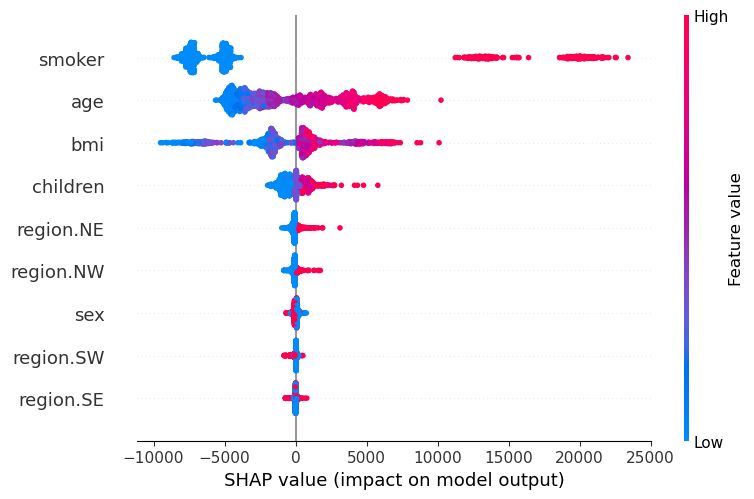

In [20]:
shap.summary_plot(shap_values, X)

### Barras

En esta gráfica podemos observar los valores absolutos promedio de los valores SHAP para cada característica.
Por ejemplo, `smoker` tiene un valor de aproximadamente 8418, por lo que ser fumador tiene el mayor impacto sobre los costos de seguro. Por otro lado, `age` tiene un valor de aproximadamente 3270, lo que indica que la edad también tiene un impacto significativo en los costos de seguro. También `bmi` tiene un valor de aproximadamente 2270, lo que indica que el índice de masa corporal también tiene un impacto significativo en los costos de seguro.

Estas tres características son las que tienen un mayor impacto en los costos de seguro, las demás características tienen un impacto menor, teniendo valores menores a 1000.

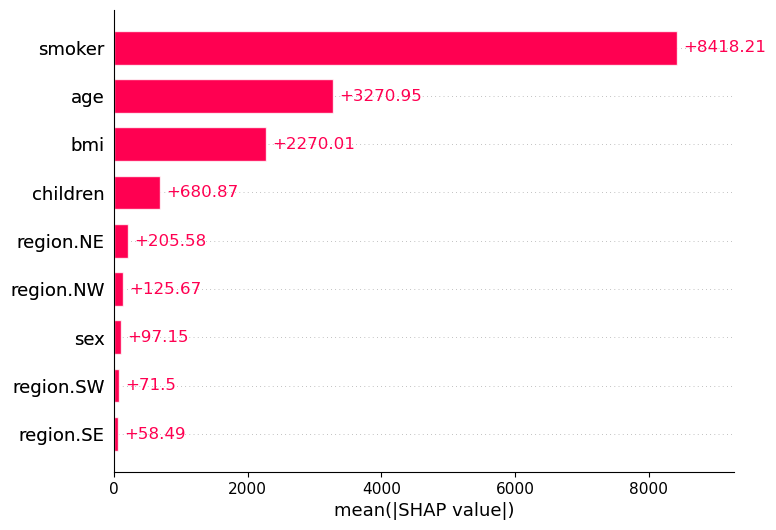

In [14]:
shap.plots.bar(shap_values)

### Waterfall
Con esta gráfica podemos observar cómo cada característica contribuye a una predicción individual.

Podemos ver como `smoker` tiene el mayor impacto ya que esta variable tiene la mayor contribución positiva a la predicción. También `sex` tiene una contribución positiva, pero mucho menor que `smoker`.

Por otro lado, `age` y `bmi` se observa que contribuyen de forma negativa, lo que significa que para este individuo específico, tener un BMI más bajo y ser relativamente joven contribuyen a reducir los costos. Por lo que, aunque globalmente estas características tienen un impacto positivo en los costos, para este individuo en particular, tener un BMI más bajo y ser más joven contribuyen a reducir los costos.

Las demás características tienen una contribución menor a la predicción, por lo que no tienen un impacto significativo en los costos de seguro para este individuo en particular.

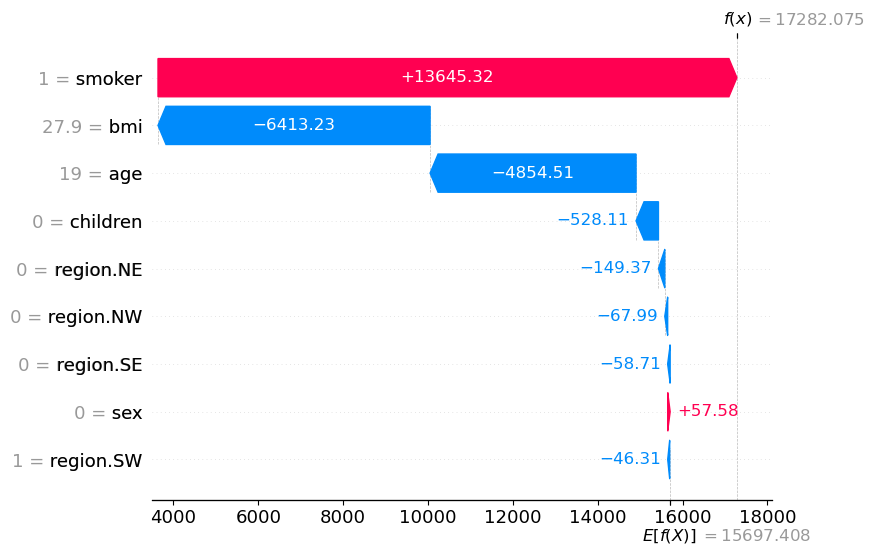

In [15]:
sample_index = 0  # Cambiar este índice para analizar otras muestras
shap_waterfall = shap_values[sample_index]
shap.plots.waterfall(shap_waterfall)

### Scatter

En las gráficas `scatter` de SHAP se puede ver la relación entre la variable de interés y su valor SHAP. Esto nos permite ver cómo se comporta la variable de interés en función de las demás variables. Un valor positivo de SHAP indica que la variable de interés incrementa el valor de la predicción, mientras que un valor negativo indica que la variable de interés disminuye el valor de la predicción.

#### Age

En la gráfica de `age` podemos observar que a medida que la edad aumenta, el valor de la predicción aumenta consigo. A partir de los 45 años los valores de SHAP son mayormente positivos, lo que indica que la edad es un factor importante para determinar el valor de la predicción. La correlación lineal que se observa indica que esta variable tiene un efecto sistemático en el valor de la predicción.

En el contexto de este dataset, se puede interpretar que a medida que la edad de una persona aumenta, el costo de su seguro médico también aumenta.

#### Sex

En esta gráfica se observan dos conjuntos, en `X=0` para mujeres y en `X=1` para hombres. Se puede observar que el valor de SHAP para las mujeres es mayormente positivo, mientras que para los hombres es mayormente negativo. Esto indica que el género de la persona tiene un impacto en el costo del seguro médico, siendo mayor para las mujeres.

#### Children

En esta gráfica se observa que a medida que el número de hijos aumenta, el valor de la predicción aumenta de manera sistemática. Esto indica que el número de hijos tiene un impacto en el costo del seguro médico, siendo mayor para las personas con más hijos. Para las personas con ningún hijo el valor de SHAP es mayormente negativo, mientras que para las personas con 1 o más hijos el valor de SHAP es mayormente positivo.

#### Smoker

En esta gráfica se observa que el valor de SHAP para las personas fumadoras es mayormente positivo, mientras que para las personas no fumadoras es mayormente negativo. Esto indica que ser fumador tiene un impacto significativo en el costo del seguro médico, siendo conmsiderablemente mayor para las personas fumadoras.

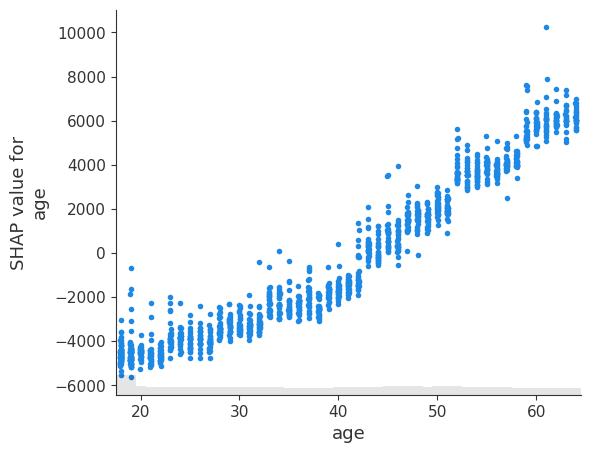

In [24]:
shap.plots.scatter(shap_values[:, "age"])

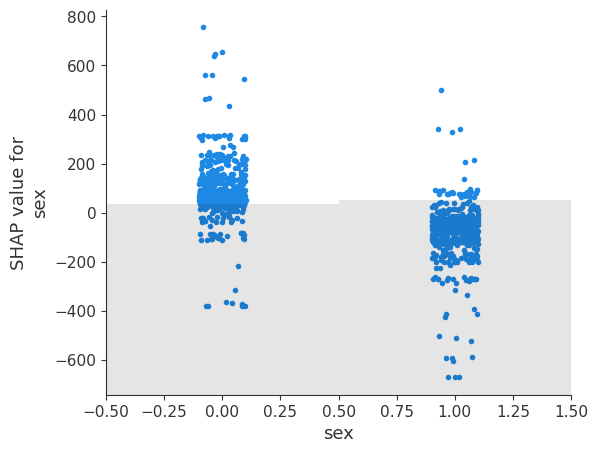

In [23]:
shap.plots.scatter(shap_values[:, "sex"])

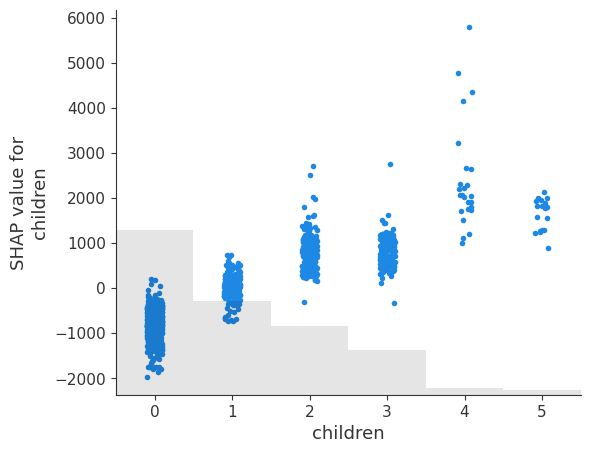

In [25]:
shap.plots.scatter(shap_values[:, "children"])

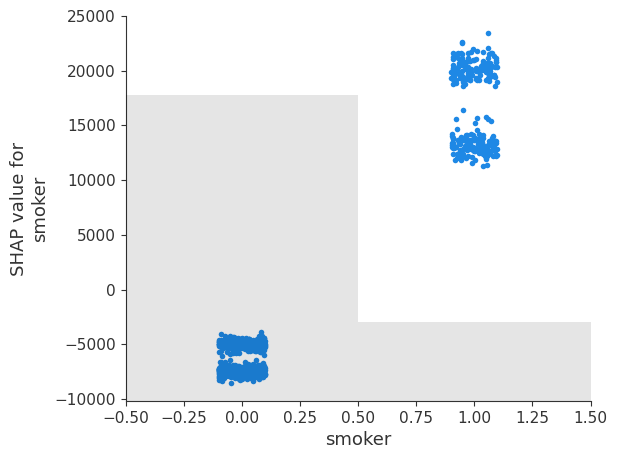

In [26]:
shap.plots.scatter(shap_values[:, "smoker"])

### Conclusiones
- Fumar es la característica más influyente en el costo del seguro médico tanto de manera global como individual.
- La edad y el índice de masa corporal también tienen un impacto significativo en el costo del seguro médico, esto hace sentido ya que a medida que la edad y el índice de masa corporal aumentan, el costo del seguro médico también aumenta.
- Las regiones y el género tienen un impacto menor en el costo del seguro médico, por lo que el modelo se enfoca más en las características como la salud y el estilo de vida de las personas.